In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [3]:
from typing_extensions import TypedDict, Annotated

from langchain.chat_models import init_chat_model
from langchain.tools import Tool
from langchain_community.tools import tool
from langchain_core.messages import HumanMessage, AnyMessage

from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.semanticscholar import SemanticScholarQueryRun
from langchain_community.utilities.semanticscholar import SemanticScholarAPIWrapper
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_experimental.tools.python.tool import PythonREPLTool 

from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from IPython.display import Image, display

In [4]:
llm = init_chat_model("gpt-4.1", temperature=0.7)

In [5]:
api_wrapper = ArxivAPIWrapper(top_k_results=5)

arxiv_tool = Tool(
    name="arxiv_search",
    description="Search Arxiv.org for academic papers. Input should be a search query, like 'quantum computing' or '1003.3568' for a specific paper ID.", 
    func=ArxivQueryRun(api_wrapper=api_wrapper).run,
)

semanticscholar_tool = Tool(
    name="semantic_scholar_search",
    description="Search for research papers on Semantic Scholar.",
    func=SemanticScholarQueryRun(api_wrapper=SemanticScholarAPIWrapper()).run,
)

api_wrapper = WikipediaAPIWrapper(top_k_results=2)

wikipedia_tool = Tool(
    name="wikipedia_search",
    description="Search Wikipedia for information on various subjects. Input should be a search query.", 
    func=WikipediaQueryRun(api_wrapper=api_wrapper).run,
)

serper_tool = Tool(
    name="serper",
    description="Search news, events, or facts using Serper-powered web search.",
    func=GoogleSerperAPIWrapper().run,
)

repl_tool = PythonREPLTool()

tools = [arxiv_tool, semanticscholar_tool, wikipedia_tool, serper_tool, repl_tool]

In [6]:
react_prompt = """
You are a helpful and precise Academic Research Assistant.

Your role is to support users by:
- **Searching for and summarizing research papers** on a given topic.
- **Retrieving information from Wikipedia** or reputable online sources.
- **Translating scientific findings or summaries** into target languages, when requested.
- **Citing sources and linking to papers** where possible.

You have access to the following tools:
- **Arxiv:** Retrieve recent/cited academic papers.
- **Wikipedia:** Get encyclopedic background.
- **Translation:** Translate text between languages.
- **Python REPL:** Execute math, statistics, or calculations.
- **Web search:** Supplement information from trusted sources.

Please reason step-by-step using this format:
Thought: Explain what you are thinking or planning to do next.  
Action: The tool you are using (with parameters).  
Action Input: What you are feeding to the tool.  
Observation: The result from the tool.

Repeat [Thought → Action → Observation] as needed.

**When you have enough information, respond in this format:**
Final Answer: <Provide a readable, referenced summary, answering the question thoroughly. Use bullet points or sections for clarity. Cite sources, and use translation if requested.>

**Never invent answers, and do NOT cite papers or results unless they are verified by your tools or sources.**
"""


In [7]:
class State(TypedDict):
    messages : Annotated[list[AnyMessage], add_messages]

In [8]:
def reasoning_node(state: State):
    # LLM with bound tools to enable tool-calling
    llm_with_tools = llm.bind_tools(tools)
    messages = [{"role": "system", "content": react_prompt}] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": state["messages"] + [response]}

In [9]:
tool_node = ToolNode(tools = tools)

In [10]:
def should_continue(state: State):
    last_message = state["messages"][-1]
    if hasattr(last_message, "content") and "final answer:" in last_message.content.lower():
        return "end"
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"
    if len(state["messages"]) > 20:
        return "end"
    # Otherwise, no tool_calls, not a final answer, so end gracefully
    return "end"

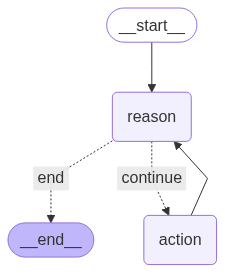

In [12]:
builder = StateGraph(State)
builder.add_node("reason", reasoning_node)
builder.add_node("action", tool_node)
builder.set_entry_point("reason")
builder.add_conditional_edges(
    "reason",
    should_continue,
    {
        "continue": "action",
        "end": END,
    }
)
builder.add_edge("action", "reason")
research_agent = builder.compile()

display(Image(research_agent.get_graph().draw_mermaid_png()))

In [14]:
query = ("""
         Summarize the most cited papers in reinforcement learning from the last two years. 
         Also, translate the main findings into Spanish.
         """)

state = {"messages": [HumanMessage(content=query)]}
result = research_agent.invoke(state)

print(result["messages"][-1].content)


Final Answer:

Below are summaries of some of the most cited and influential reinforcement learning (RL) papers from the last two years, along with their main findings translated into Spanish.

---

### 1. Transfer Learning in Deep Reinforcement Learning: A Survey (2023)
- **Main Findings (English):**
  - Transfer learning addresses the data inefficiency and slow convergence of deep RL by transferring knowledge from source tasks or domains.
  - The survey categorizes transfer learning methods, analyzing their goals, methodologies, and applications in deep RL.
  - Challenges include negative transfer, transferability estimation, and scalable frameworks.

- **Resumen en Español:**
  - El aprendizaje por transferencia aborda la ineficiencia de datos y la lenta convergencia del aprendizaje por refuerzo profundo al transferir conocimientos de tareas o dominios fuente.
  - La revisión categoriza los métodos de aprendizaje por transferencia, analizando sus objetivos, metodologías y aplicacion

In [13]:
query = ("Hi")

state = {"messages": [HumanMessage(content=query)]}
result = research_agent.invoke(state)

print(result["messages"][-1].content)

Hello! How can I help you today? If you need research papers, summaries, translations, or academic information, just let me know your topic or question.
